In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Introduction to AI and OpenVino

## Lecture 10

### Neural Network with :
- Fashion MNIST
- all regularization


<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf

2024-06-17 17:10:04.934901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 17:10:04.934949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 17:10:04.936062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 17:10:04.942769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 17:10:05.872511: W tensorflow/compiler/tf2

In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'
# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15,6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.bwr_r
plt.rcParams.update(params)
plt.set_cmap(CMAP)

plt.style.use('bmh')

EPOCHS = 100   # number of cycles to run
ALPHA = 0.001 # learning rate
BATCH_SIZE = 32

ES_PATIENCE = 10 # if performance does not improve stop
LR_PATIENCE = 5 # if performance is not improving reduce alpha
LR_FACTOR = 0.1 # rate of reduction of alpha

<Figure size 1500x600 with 0 Axes>

In [4]:
### Settings so that Tensorflow can not Hog all the GPU memory
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-06-17 17:10:06.859317: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 17:10:06.900494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 17:10:06.900837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Helper Functions

In [5]:
# Function to plot history
def fn_plot_hist(hist_df):

    fig, axes = plt.subplots(1,2 , figsize = (15,6)) 

    props = dict(boxstyle='round', facecolor='cyan', alpha=0.4, 
                 edgecolor = 'b')

    ax = axes[0]

    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], 
                 ax = ax,
                 colormap=CMAP) 

    lossmin = hist_df[hist_df.columns[0]].min()
    
    testmin = hist_df[hist_df.columns[2]].min()

    fmtStr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}"

    txtstr = fmtStr.format(hist_df.columns[0], lossmin, testmin) #text to plot

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())
    
    ax = axes[1]

    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]],
                 ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    
    testmin = hist_df[hist_df.columns[3]].max()
    
    fmtStr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}"
    txtstr = fmtStr.format(hist_df.columns[1], accmin, testmin) #text to plot
    
    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes,fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    
    ax.set_ylabel(hist_df.columns[1].capitalize())
    
    plt.tight_layout()

## Read Fashion DataSet

In [6]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:


In [7]:
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [8]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [9]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


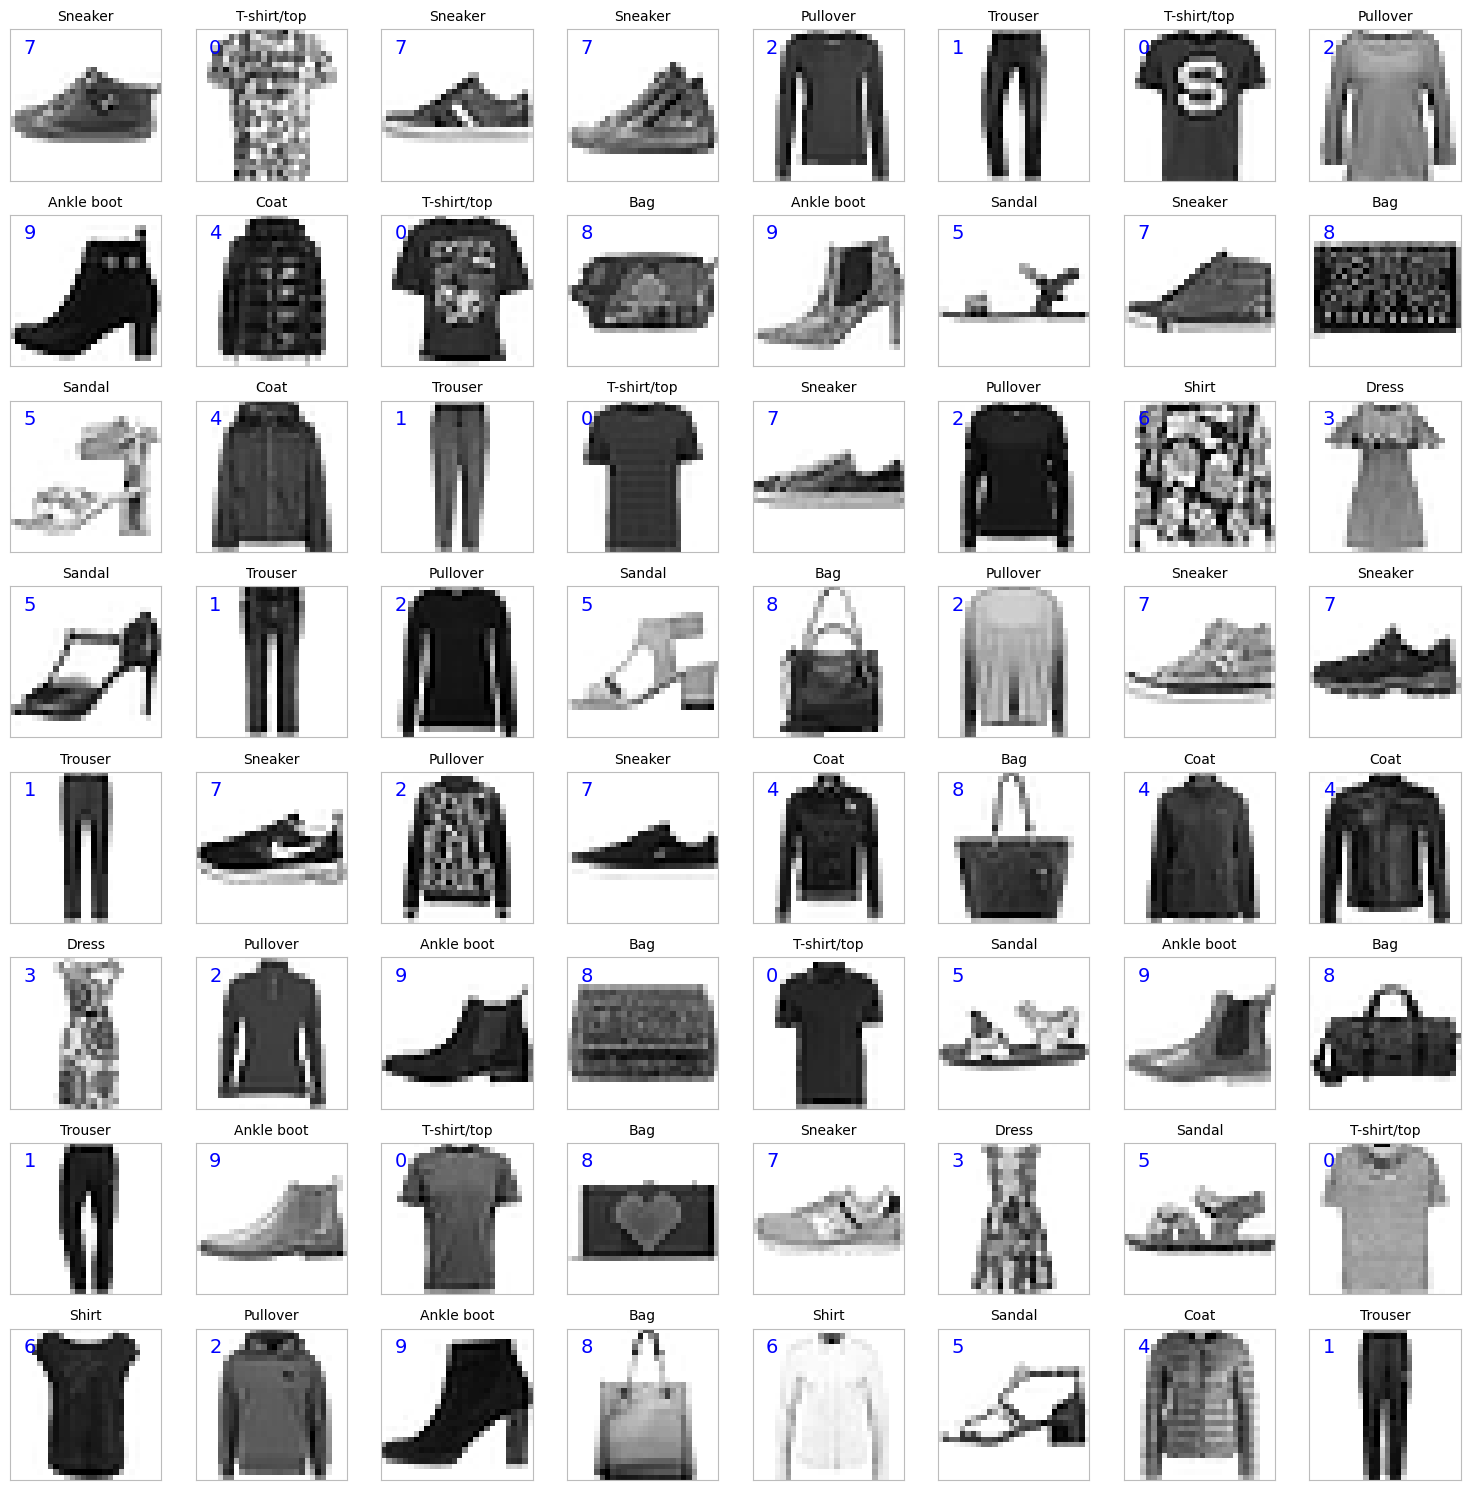

In [10]:
# Sample data plot

plot_df = train_df.sample(n = 64) # Take 64 sample from the training set

fig = plt.figure(figsize=(15, 15))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(8, 8, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(2, 4, str(row.iloc[0]), color='b', fontsize=14)   # add number (class) of the image
    
    ax.set_title(class_names[row.iloc[0]], fontsize=10)   # add name of the image

plt.tight_layout() 
plt.show()

In [11]:
X_train = train_df.drop('label', axis = 1).to_numpy()
y_train = train_df['label'].to_numpy()

X_test = test_df.drop('label', axis = 1).to_numpy()
y_test = test_df['label'].to_numpy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [12]:
X_train.max()

255

In [13]:
X_train = X_train / 255.0

X_test = X_test / 255.0

## Prepare Model

Build `tf.keras.Sequential` model by taking `tf.keras.layers.Dense`

In [14]:
784//16

49

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(784//4, activation='relu'),
    tf.keras.layers.Dense(784//16, activation='relu'),
    tf.keras.layers.Dense(10) # Ten classes
    ])
#model.output_shape

2024-06-17 17:10:12.095850: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 17:10:12.096116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 17:10:12.096303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [16]:
X_train[:1].shape

(1, 784)

In [17]:
predictions = model(X_train[:1])
predictions.numpy().sum()

-3.3655462

In [18]:
tf.nn.softmax(predictions).numpy().sum()

1.0

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 196)                  153860    
                                                                 
 dense_1 (Dense)             (1, 49)                   9653      
                                                                 
 dense_2 (Dense)             (1, 10)                   500       
                                                                 
Total params: 164013 (640.68 KB)
Trainable params: 164013 (640.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [21]:
y_train[:1]

array([2])

In [22]:
loss_fn(y_train[:1], predictions).numpy()

1.7186953

## Compile the model:
- Loss Function
- Optimizer
- list metrics to monitor

## Fit the model
- Training features
- Training target
- validations
- batch_size
- epochs


In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
              loss=loss_fn,
              metrics=['accuracy'])

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose='auto',
                    validation_data=[X_test, y_test])

Epoch 1/100


2024-06-17 17:10:13.562512: I external/local_xla/xla/service/service.cc:168] XLA service 0x71b2e5ab44a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-17 17:10:13.563005: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-17 17:10:13.575213: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-17 17:10:13.600494: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1718624413.697299   11193 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 6s 2ms/step - loss: 0.4961 - accuracy: 0.8220 - val_loss: 0.3915 - val_accuracy: 0.8593
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3703 - accuracy: 0.8640 - val_loss: 0.3710 - val_accuracy: 0.8630
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3322 - accuracy: 0.8788 - val_loss: 0.3659 - val_accuracy: 0.8640
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3131 - accuracy: 0.8846 - val_loss: 0.3471 - val_accuracy: 0.8730
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2936 - accuracy: 0.8916 - val_loss: 0.3083 - val_accuracy: 0.8843
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2763 - accuracy: 0.8964 - val_loss: 0.2966 - val_accuracy: 0.8907
Epoch 7/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2658 - accuracy: 0.9006 - val_loss: 0.3054 - val_accuracy: 0.88

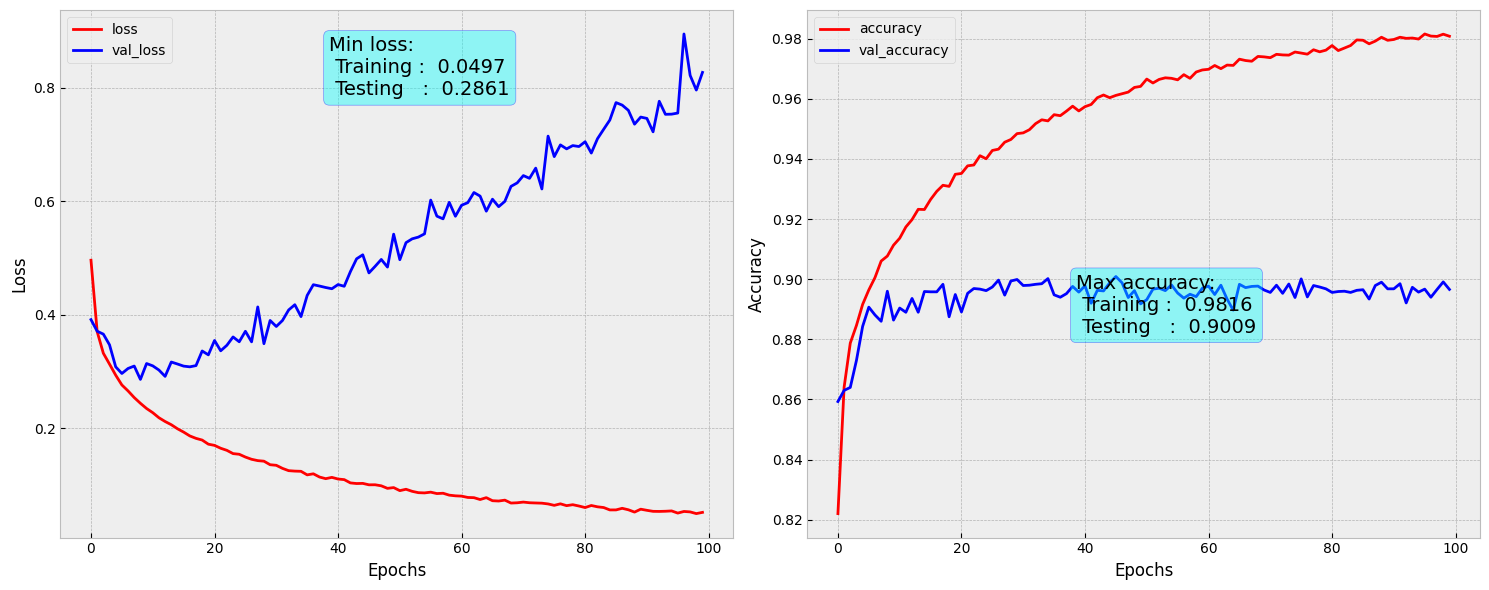

In [24]:
hist_df = pd.DataFrame(history.history)
fn_plot_hist(hist_df)

In [29]:
y_pred = model.predict(X_train)
y_pred = y_pred.argmax(axis = 1)
print('Accuracy score on Train Data :', accuracy_score(y_train, y_pred))

1875/1875 [==============================] - 2s 964us/step
Accuracy score on Train Data : 0.98495


In [30]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6000
           1       1.00      1.00      1.00      6000
           2       0.97      0.96      0.97      6000
           3       0.98      1.00      0.99      6000
           4       0.97      0.96      0.96      6000
           5       1.00      1.00      1.00      6000
           6       0.96      0.97      0.96      6000
           7       1.00      0.99      1.00      6000
           8       1.00      1.00      1.00      6000
           9       0.99      1.00      1.00      6000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



In [31]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print('Accuracy score on Test Data :', accuracy_score(y_test, y_pred))

313/313 [==============================] - 0s 921us/step
Accuracy score on Test Data : 0.8966


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.84      0.81      0.82      1000
           3       0.89      0.92      0.90      1000
           4       0.84      0.84      0.84      1000
           5       0.98      0.94      0.96      1000
           6       0.72      0.73      0.73      1000
           7       0.94      0.93      0.94      1000
           8       0.98      0.97      0.98      1000
           9       0.92      0.97      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [33]:
cm  = confusion_matrix(y_test, y_pred)
cm

array([[850,   1,  16,  23,   1,   0, 106,   0,   3,   0],
       [  1, 984,   1,  12,   0,   0,   2,   0,   0,   0],
       [ 15,   1, 813,  12,  72,   0,  84,   0,   3,   0],
       [ 13,   7,   9, 924,  24,   0,  22,   0,   1,   0],
       [  0,   0,  67,  35, 837,   1,  59,   0,   1,   0],
       [  0,   0,   1,   0,   0, 943,   0,  34,   1,  21],
       [110,   2,  57,  34,  55,   0, 734,   0,   8,   0],
       [  0,   0,   0,   0,   0,   8,   0, 934,   1,  57],
       [  1,   0,   7,   2,   3,   1,  11,   0, 974,   1],
       [  0,   0,   0,   0,   0,   5,   0,  22,   0, 973]])

In [1]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.grid(False)
plt.show();

NameError: name 'ConfusionMatrixDisplay' is not defined

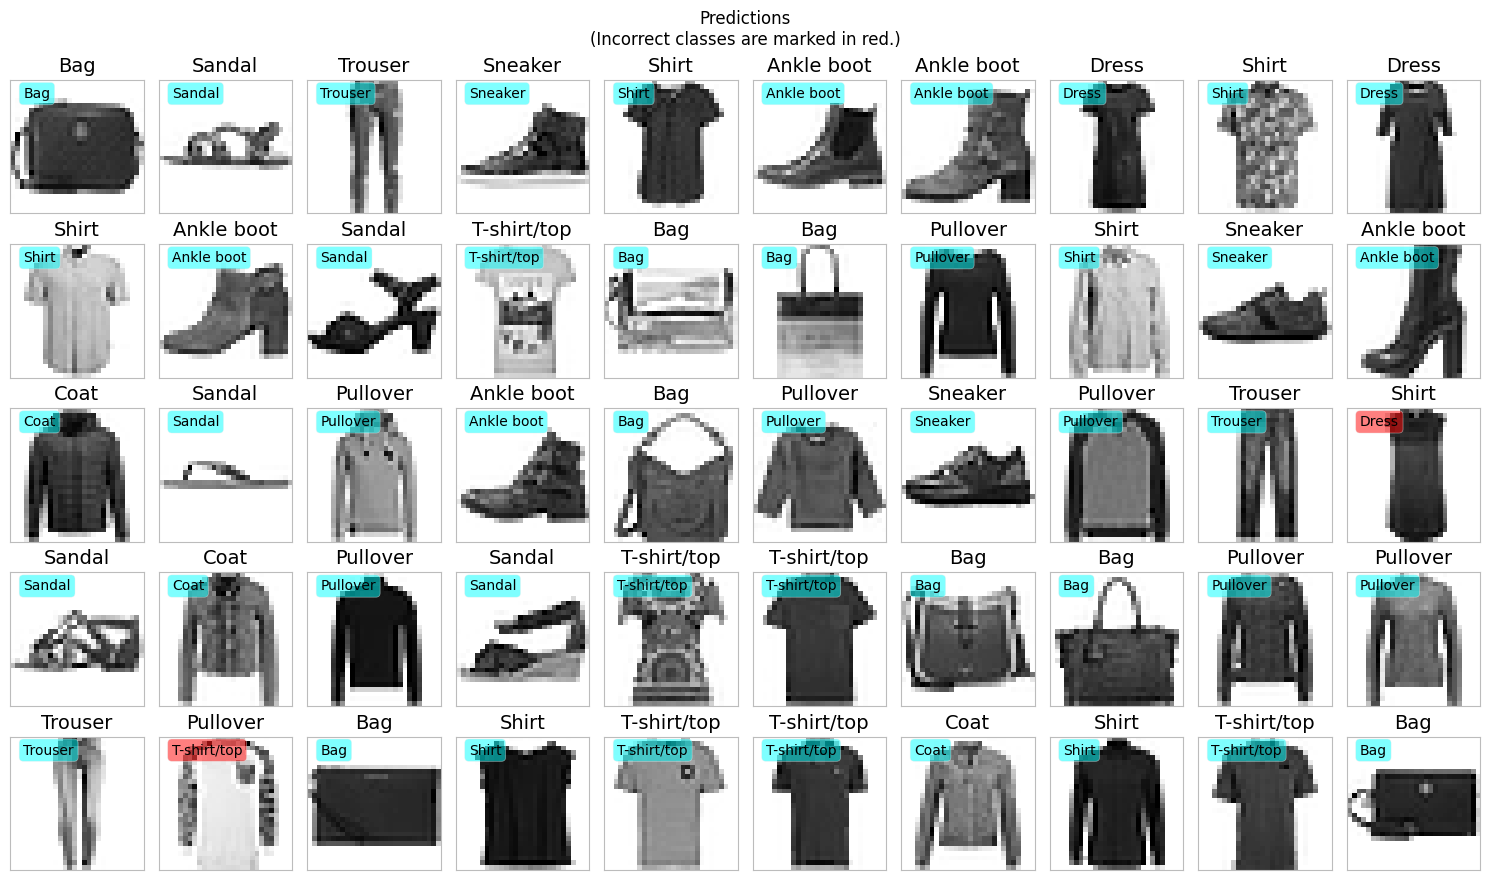

In [39]:
# Results data plot

test_df['y_pred'] = y_pred

plot_df = test_df.sample(n = 50) # Take 50 sample from the training set

fig = plt.figure(figsize=(15, 9))  # figure size in inches

i = 0

fntsize = 14

for _, row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:-1].reshape(28,28) # reshape row to a 28x28 matrix
    
    if row.iloc[0]!= row.iloc[-1]:
        color = 'red'
    else:
        color = 'cyan'

    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    
    ax = fig.add_subplot(5, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.set_title(class_names[row.iloc[0]], fontsize=fntsize)   # add number (class) of the image
    
    ax.text(0.1, 0.95, class_names[row.iloc[-1]], transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)   # add number (class) of the image
    
fig.suptitle('Predictions\n(Incorrect classes are marked in red.)')
plt.tight_layout()
plt.show()